# 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags, kron, eye, linalg
from scipy.sparse.linalg import  spsolve

In [7]:
def A_matrix(n):
    ones = np.ones(n-1);
    T = spdiags([-ones,8*ones,-ones], [-1,0,1])
    S = spdiags([ones, ones, ones], [-1,0,1])
    return 3*n*kron(eye(n-1), T) - 3*n*kron(spdiags([ones, ones], [-1, 1]), S)
A_matrix(4).toarray()

array([[ 96., -12.,   0., -12., -12.,   0.,   0.,   0.,   0.],
       [-12.,  96., -12., -12., -12., -12.,   0.,   0.,   0.],
       [  0., -12.,  96.,   0., -12., -12.,   0.,   0.,   0.],
       [-12., -12.,   0.,  96., -12.,   0., -12., -12.,   0.],
       [-12., -12., -12., -12.,  96., -12., -12., -12., -12.],
       [  0., -12., -12.,   0., -12.,  96.,   0., -12., -12.],
       [  0.,   0.,   0., -12., -12.,   0.,  96., -12.,   0.],
       [  0.,   0.,   0., -12., -12., -12., -12.,  96., -12.],
       [  0.,   0.,   0.,   0., -12., -12.,   0., -12.,  96.]])

In [9]:
def M_matrix(n):
    ones = np.ones(n-1);
    Q = spdiags([ones, 4*ones, ones], [-1,0,1])
    return 1/n*kron(Q, Q/4)

In [35]:
def problem_2_solve(n):
    print(f"Debug: Solving problem 1 for n={n}")
    A = A_matrix(n).tocsc()
    M = M_matrix(n)


    x = y = np.arange(1,n) / n
    X, Y = np.meshgrid(x,y)

    f = 5 * np.pi**2 * np.sin(2*np.pi*X)*np.sin(np.pi*Y)
    b = f.reshape(((n-1)**2, 1))
    
    prod = M.dot(b)
    return linalg.spsolve(A, prod), (X,Y)

In [40]:
ns = [4,8,16,32,64]
us = [ problem_2_solve(n) for n in ns ]

Debug: Solving problem 1 for n=4
Debug: Solving problem 1 for n=8
Debug: Solving problem 1 for n=16
Debug: Solving problem 1 for n=32
Debug: Solving problem 1 for n=64


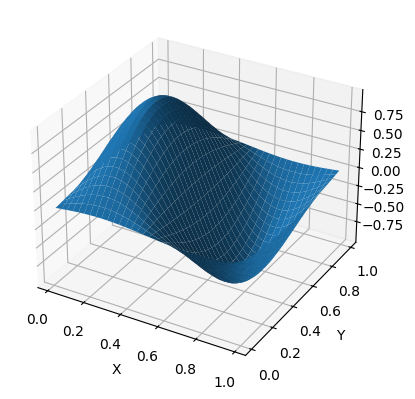

In [37]:
def problem_2_plot(u, XY):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    ax.plot_surface(XY[0],XY[1],u.reshape(XY[0].shape))
    return fig
problem_2_plot(*us[-1]);